In [1]:
using CSV
using DataFrames
using Distributions
using ShiftedArrays
using StatsPlots
using Optim
#using Turing

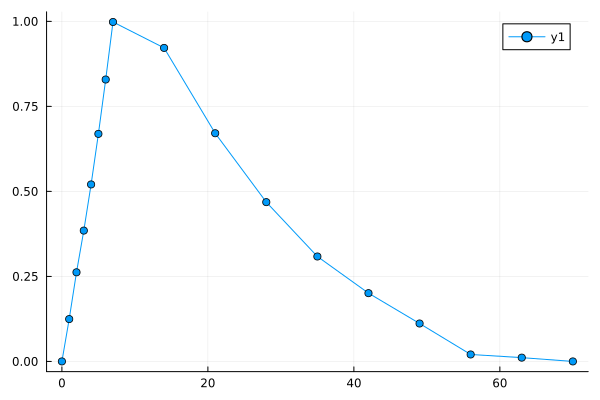

In [2]:
df = CSV.read("../data/Radboud_2013_Pt.csv", DataFrame)
plot(df[:, "day"], df[:, "Pt"], marker=:circle)

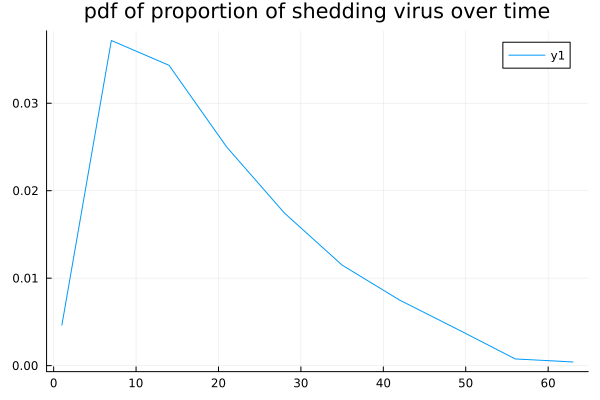

In [3]:
lis = append!([2], 8:16)
df_pt = df[lis,:]
scale = df_pt[:, :Pt] .* 7
df_pt[:,"pdf"] = df_pt[:, :Pt]/sum(scale)
df_pt[!, :day] = df_pt[:, :day] .|> Float64
plot(df_pt[:, :day], df_pt[:,:pdf], title="pdf of proportion of shedding virus over time")

In [4]:
pt = df_pt[:, :pdf]
days = df_pt[:, :day]
function KLd(x)
    α = x[1]
    θ = x[2]
    qt = Distributions.pdf.(Gamma(α, θ), days)
    d = pt .* (log.(pt) .- log.(qt))
    return sum(d)
end

KLd (generic function with 1 method)

In [5]:
res = optimize(KLd, [0.0,0.0], [Inf, Inf], [1.0, 10.0])

 * Status: success

 * Candidate solution
    Final objective value:     1.713427e-05

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 7.72e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.44e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.90e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    3
    f(x) calls:    46
    ∇f(x) calls:   46


2.164630300162043, 8.882902209623476


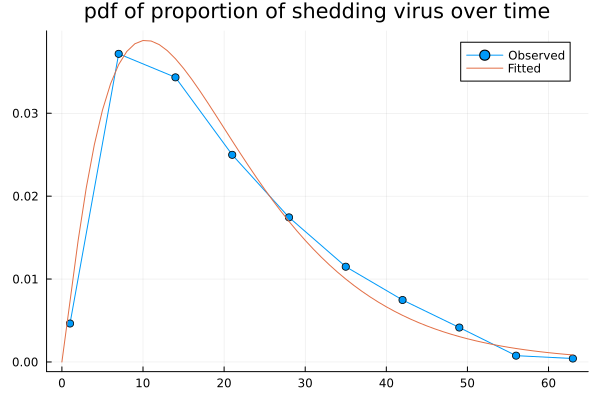

In [6]:
α, θ = Optim.minimizer(res)
println("$α, $θ")
x = 0:63
y = pdf.(Gamma(α, θ), x) 
pl = plot(title="pdf of proportion of shedding virus over time")
plot!(pl, days, pt, label="Observed", marker=:circle)
plot!(pl, x, y, label="Fitted")
display(pl)

In [7]:
pt = df_pt[:, :pdf]
days = df_pt[:, :day]
function conv(t, γ2; γ1 = 1/4.0)
    return γ1*γ2/(γ1 - γ2)*(exp(-γ2*t) - exp(-γ1*t))
end
function target(x)
    γ2 = x[1]
    qt = conv.(days, γ2)
    d = pt .* (log.(pt) .- log.(qt))
    return sum(d)
end

res = optimize(target, [0], [1/4.0], [1/8])

 * Status: success

 * Candidate solution
    Final objective value:     4.201753e-03

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 1.69e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.53e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.05e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    3
    f(x) calls:    18
    ∇f(x) calls:   18


In [8]:

γ2 = Optim.minimizer(res)
println("$γ2 , $(1/γ2)")

[0.06657668438302566] , [15.020273377491282;;]


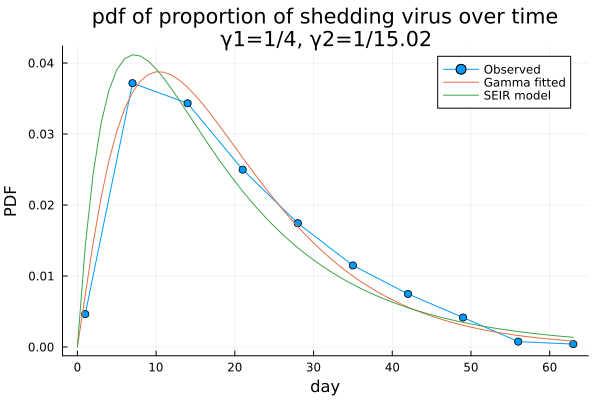

In [9]:
x = 0:63
y_conv = conv.(x, γ2)
y_gamma = pdf.(Gamma(α, θ), x) 
pl = plot(title="pdf of proportion of shedding virus over time\nγ1=1/4, γ2=1/15.02",
    xlabel="day", ylabel="PDF",
    fmt=:png,
)
plot!(pl, days, pt, label="Observed", marker=:circle)
plot!(pl, x, y_gamma, label="Gamma fitted")
plot!(pl, x, y_conv, label="SEIR model")
display(pl)

# Hazard rate

0.23025850929940458


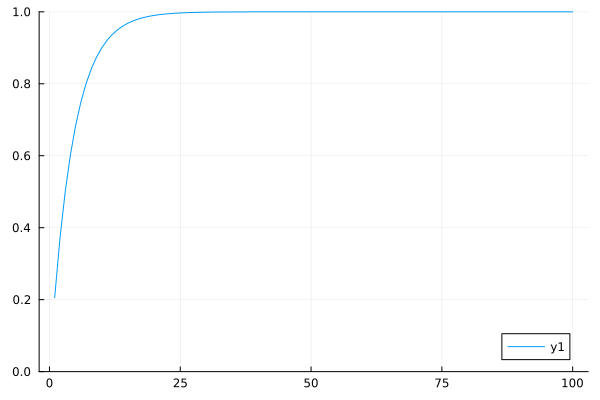

In [31]:
p = 0.9
λ0 = - log(1-p)/10
println(λ0)
I = 1:100
ωt = 1 .- exp.(-λ0.*I)
plot(I, ωt, ylim=[0,1.0])